In [2]:
import json

import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import interp1d
import pandas as pd
import numpy as np
mpl.style.use('ggplot')
%matplotlib inline
from tqdm import tqdm


/usr/local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Histogram and P-values

In [3]:
#folder = "results"
folder = "/Users/kipnisal/Google Drive/results"
dataset = "abstracts"
context = "no_context"
model = "gpt2-xl"
#model = "gpt-neo-1.3B"
name = f"{model}_{context}_{dataset}"
data_machine = pd.read_csv(f"{folder}/{name}_machine.csv")
data_human = pd.read_csv(f"{folder}/{name}_human.csv")

In [4]:
if dataset == "news" and model == "gpt-neo-1.3B":
    data_human['length'] /= 5
    print("Adjusting char to tokens")

In [5]:
MAX_TOKENS_PER_SENTENCE = 50
MIN_TOKENS_PER_SENTENCE = 7

In [6]:
datar = pd.concat([data_machine, data_human])
if dataset == 'wiki':
    human_author =  'Wikipedia'
    machine_author = 'GPT3'
    data_machine['author'] = 'GPT3'
if dataset == 'news':
    human_author =  'CNN/DailyMail'
    machine_author = 'ChatGPT'
if dataset == 'abstracts':
    human_author =  'scientific abstract'
    machine_author = 'ChatGPT'


data_machine['author'] = machine_author
data_human['author'] = human_author

datar = pd.concat([data_machine, data_human])

datar = datar[(MIN_TOKENS_PER_SENTENCE <= datar.length) & (datar.length <= MAX_TOKENS_PER_SENTENCE)]
datar = datar.groupby('response').head(1) # remove repeated entries
datar = datar.rename(columns={'sent_num': 'num'})
זסדש

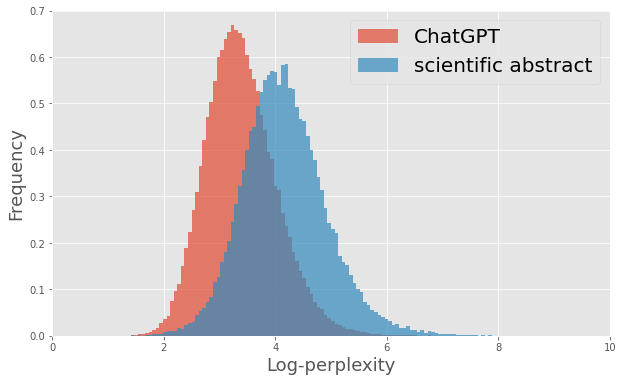

                         mean    median       std      skew  kurtosis
author                                                               
ChatGPT              3.400445  3.352636  0.655297  0.485037  0.682057
scientific abstract  4.137785  4.096673  0.757242  0.417677  0.897944


In [7]:
from scipy.stats import norm

IGNORE_FIRST_SENTENCE = True
if context == 'previous_sentence' or IGNORE_FIRST_SENTENCE:
    data_disp = datar[datar.num>1]

tt = np.linspace(0,10,157)
data_disp.groupby('author').response.plot.hist(bins = tt, density=True, alpha=.7, legend=True)
plt.legend(fontsize=20)
plt.ylabel('Frequency', size=18)
plt.xlabel('Log-perplexity', size=18)

fig = plt.gcf()
fig.set_size_inches(10, 6, forward=True)


plt.savefig(f"Figs/{name}.png")
plt.xlim((0,10))
plt.show()
#

def kurtosis(x):
    return scipy.stats.kurtosis(x)
agg_stats = datar.groupby('author').response.agg(['mean','median', 'std', 'skew', kurtosis])
print(agg_stats)

## Perplexity Vs. Length

In [8]:
def plot_perp_vs_len(data, min_len=5, max_len=160):
    df_grouped = (
        data[['length', 'response']][(data['length'] >= min_len)
                                    & (data['length'] <= max_len)
                                    ].groupby(['length']).agg(['mean', 'std', 'count'])
    )
    df_grouped = df_grouped.droplevel(axis=1, level=0).reset_index()
    # Calculate a confidence interval as well.
    df_grouped['ci'] = 1.96 * df_grouped['std'] / np.sqrt(df_grouped['count'])
    df_grouped['ci_lower'] = df_grouped['mean'] - df_grouped['ci']
    df_grouped['ci_upper'] = df_grouped['mean'] + df_grouped['ci']
    df_grouped.head()

    fig, ax = plt.subplots()
    x = df_grouped['length']
    ax.plot(x, df_grouped['mean'])
    ax.fill_between(
        x, df_grouped['ci_lower'], df_grouped['ci_upper'], color='b', alpha=.15)
    ax.set_ylim(ymin=0)
    ax.set_title('log perplexity vs. length')
    ax.set_xlabel("Sentence Length [tokens]", fontsize=18)
    ax.set_ylabel("Log Perplexity [nats]", fontsize=18)
    ax.set_ylim((2, 4))
    plt.rcParams["figure.figsize"] = (8, 5)


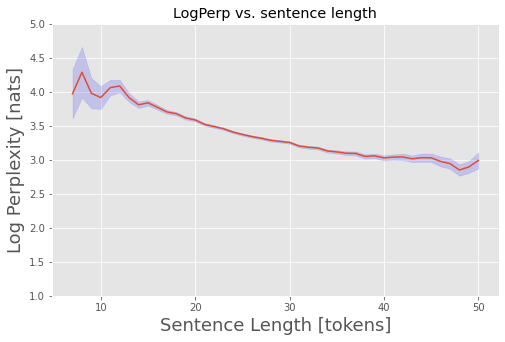

In [15]:
IGNORE_FIRST_SENTENCE = True
if context == 'previous_sentence' or IGNORE_FIRST_SENTENCE:
    data_disp = datar[datar.num>1]

plot_perp_vs_len(data_disp[data_disp.author == machine_author], min_len=5, max_len=50)
plt.title("LogPerp vs. sentence length")
plt.ylim([1,5])
plt.savefig(f"Figs/logperp_vs_len_{name}.png")
plt.show()

 # Perplexity of first sentences vs. the rest

<Figure size 576x360 with 0 Axes>

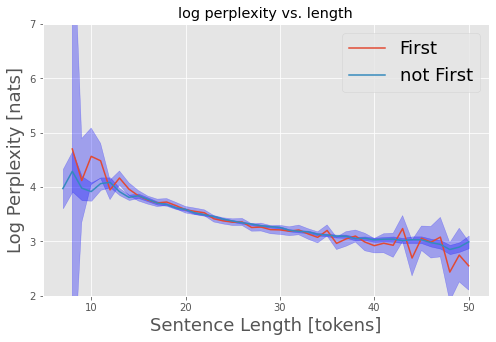

In [10]:
plt.figure()

min_len = 5
max_len = 50

data = datar[(datar.num == 1) & (datar.author == machine_author)]
df_grouped = (
        data[['length', 'response']][(data['length'] >= min_len)
                                        & (data['length'] <= max_len)
                                       ].groupby(['length']).agg(['mean', 'std', 'count'])
    )
df_grouped = df_grouped.droplevel(axis=1, level=0).reset_index()
# Calculate a confidence interval as well.
df_grouped['ci'] = 1.96 * df_grouped['std'] / np.sqrt(df_grouped['count'])
df_grouped['ci_lower'] = df_grouped['mean'] - df_grouped['ci']
df_grouped['ci_upper'] = df_grouped['mean'] + df_grouped['ci']
df_grouped.head()

fig, ax = plt.subplots()
x = df_grouped['length']
ax.plot(x, df_grouped['mean'], label='First')
ax.fill_between(
    x, df_grouped['ci_lower'], df_grouped['ci_upper'], color='b', alpha=.3)

# second
data = datar[(datar.num >= 2) & (datar.author == machine_author)]
df_grouped = (
        data[['length', 'response']][(data['length'] >= min_len)
                                        & (data['length'] <= max_len)
                                       ].groupby(['length']).agg(['mean', 'std', 'count'])
    )
df_grouped = df_grouped.droplevel(axis=1, level=0).reset_index()
# Calculate a confidence interval as well.
df_grouped['ci'] = 1.96 * df_grouped['std'] / np.sqrt(df_grouped['count'])
df_grouped['ci_lower'] = df_grouped['mean'] - df_grouped['ci']
df_grouped['ci_upper'] = df_grouped['mean'] + df_grouped['ci']
df_grouped.head()

x = df_grouped['length']
ax.plot(x, df_grouped['mean'], label='not First')
ax.fill_between(
    x, df_grouped['ci_lower'], df_grouped['ci_upper'], color='b', alpha=.3)

ax.legend()
ax.set_ylim(ymin=0)

plt.legend(fontsize=18)

ax.set_title('log perplexity vs. length')
ax.set_xlabel("Sentence Length [tokens]", fontsize=18)
ax.set_ylabel("Log Perplexity [nats]", fontsize=18)
plt.rcParams["figure.figsize"] = (8,5)

plt.savefig(f"Figs/logperp_vs_len_first_sentence_{name}.png")
plt.ylim([2,7])
plt.show()

# ROC and risk analysis

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score
datas = datar[datar.num > 0]
fpr, tpr, thresholds = roc_curve(y_true=datas.author, y_score=datas.response, pos_label=human_author)

mdr = 1 - tpr
istar = np.argmin(fpr + mdr)
Rstar = fpr[istar] + mdr[istar]
Rsxy = (fpr[istar], tpr[istar])

alpha = 0.05
A005xy = (alpha, tpr[fpr <= alpha].max())
beta = 1 - tpr[fpr <= alpha].max()
Del = norm.isf(alpha) - norm.ppf(beta)  # effect size on the Z-scale
y_true = (datas.author == human_author)
auc = roc_auc_score(y_true=y_true, y_score=datas.response)

import json
res = dict(name=name, alpha=alpha, beta=beta, delta=Del,
           Rstar = Rstar,
           AUC=auc)
with open(f"results/atomic_results_{name}.json", "w") as f:
    json.dump(res, f, indent=True)
print(res)

{'name': 'gpt2-xl_no_context_abstracts', 'alpha': 0.05, 'beta': 0.7291316931982634, 'delta': 1.0346646238851336, 'Rstar': 0.5793781835447576, 'AUC': 0.7766951621424645}


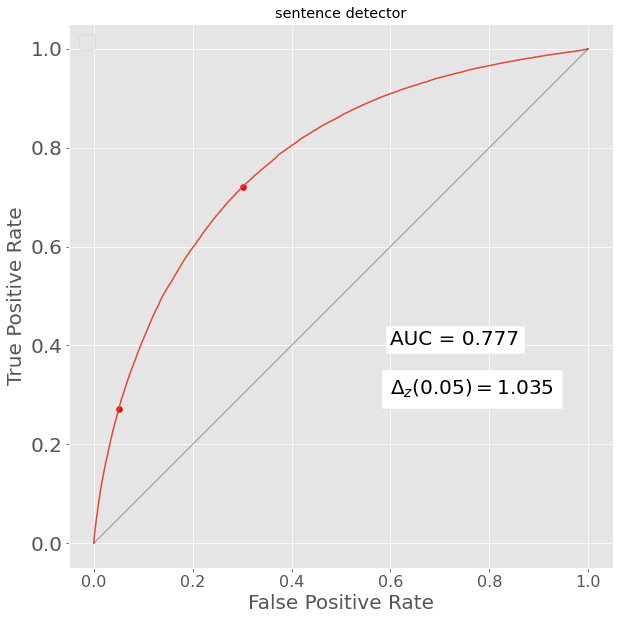

In [12]:
display = RocCurveDisplay(fpr=fpr, tpr=tpr)
display.plot(label='logloss')
plt.plot([0, 1], [0, 1], "k", alpha=.25)

plt.scatter(Rsxy[0], Rsxy[1], c='r')
plt.scatter(A005xy[0], A005xy[1], c='r')

plt.axis("square")
plt.xlabel("False Positive Rate", fontsize=20)
plt.ylabel("True Positive Rate", fontsize=20)
plt.xticks(fontsize=16); plt.yticks(fontsize=20)
fig = plt.gcf()
fig.set_size_inches(10, 10, forward=True)
plt.legend([],fontsize=20)
plt.text(.6,0.40,s=f"AUC = {np.round(res['AUC'],3)}", size=20, backgroundcolor='w')
plt.text(.6,0.30,s=f"$\Delta_z({alpha}) = {np.round(res['delta'],3)}$", backgroundcolor='w', size=20)
plt.title("sentence detector")
plt.savefig(f"Figs/ROC_sentences_{name}.png")
plt.show()

# Comparing two models

In [13]:
#compare two models:
dataset = 'wiki-long'
model_x = "gpt2"
model_y = "gpt-neo-1.3B"

name_x = f"{model_x}_{context}_{dataset}"
name_y = f"{model_y}_{context}_{dataset}"
data_x_machine = pd.read_csv(f"results/{name_x}_machine.csv")
data_y_machine = pd.read_csv(f"results/{name_y}_machine.csv")

data_x_human = pd.read_csv(f"results/{name_x}_human.csv")
data_y_human = pd.read_csv(f"results/{name_y}_human.csv")

data_merged_machine = data_x_machine.merge(data_y_machine, on=['name', 'num'], how='inner')
data_merged_human = data_x_human.merge(data_y_human, on=['name', 'num'], how='inner')

# Skewness and Kurtosis

In [14]:
def kurtosis(x):
    return scipy.stats.kurtosis(x)
agg_stats = datar.groupby('author').response.agg(['mean','median', 'std', 'skew', kurtosis])
print(agg_stats)

                         mean    median       std      skew  kurtosis
author                                                               
ChatGPT              3.400445  3.352636  0.655297  0.485037  0.682057
scientific abstract  4.137785  4.096673  0.757242  0.417677  0.897944
